In [13]:
import pandas as pd
from tqdm import tqdm
import missingno as msgno
import numpy as np

from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MultiLabelBinarizer 
import matplotlib.colors

sns.set()

In [2]:
# Graphics
colors = {'title':'#323232', 'positive': '#008794', 'negative':'#DD24B6'}
fontfamily_titles = 'bagnard'
fontfamily_numbers = 'monospace'
plt.rcParams["font.family"] = "monospace"
backgrouond_color = '#fafafa'

In [3]:
data = pd.read_csv('../data/01-nypd-complaints-clean.csv').drop('Unnamed: 0', axis=1)
data.date_start = pd.to_datetime(data.date_start)
data.date_reported = pd.to_datetime(data.date_reported)
data.head()

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cmp_id,date_start,time_start,date_end,time_end,loc_precinct,date_reported,key_code,offense_desc,internal_desc,...,jurisdiction_desc,park_name,susp_age_group,susp_race,susp_sex,transit_district,loc_borough_patrol,vic_age_group,vic_race,vic_sex
0,394506329,2019-12-31,17:30:00,NaN,NaN,32.0,2019-12-31,118,DANGEROUS WEAPONS,WEAPONS POSSESSION 3,...,N.Y. POLICE DEPT,NaN,UNKNOWN,NaN,NaN,NaN,PATROL BORO MAN NORTH,UNKNOWN,UNKNOWN,E
1,968873685,2019-12-29,16:31:00,12/29/2019,16:54:00,47.0,2019-12-29,113,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,N.Y. POLICE DEPT,NaN,UNKNOWN,NaN,NaN,NaN,PATROL BORO BRONX,UNKNOWN,UNKNOWN,E
2,509837549,2019-12-15,18:45:00,NaN,NaN,109.0,2019-12-29,578,HARRASSMENT 2,"HARASSMENT,SUBD 3,4,5",...,N.Y. POLICE DEPT,NaN,25-44,UNKNOWN,M,NaN,PATROL BORO QUEENS NORTH,25-44,WHITE HISPANIC,F
3,352454313,2019-12-28,01:00:00,NaN,NaN,47.0,2019-12-28,126,MISCELLANEOUS PENAL LAW,RECKLESS ENDANGERMENT 1,...,N.Y. POLICE DEPT,NaN,18-24,BLACK,M,NaN,PATROL BORO BRONX,UNKNOWN,UNKNOWN,E
4,248803469,2008-09-05,21:41:00,NaN,NaN,NaN,2008-09-05,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,N.Y. POLICE DEPT,NaN,UNKNOWN,NaN,NaN,NaN,NaN,25-44,BLACK,M


In [4]:
SEX_OFFENSES = ['SEX CRIMES', 'RAPE']
data_sex = data.query('offense_desc in @SEX_OFFENSES')

data_sex.offense_desc = data_sex.offense_desc.apply(lambda of: 'SEX CRIMES' if of == 'RAPE' else of)
data_sex.internal_desc = data_sex.internal_desc\
    .apply(lambda of:'RAPE' if of.startswith('RAPE') else of)

# map subcategories into a bigger group
SEX_OFFENSE_CATEGORY_MAP = {
    'SEXUAL ABUSE 3,2': 'Sex Abuse',
    'CHILD, ENDANGERING WELFARE': 'Child Endangerment',
    'SEXUAL MISCONDUCT,INTERCOURSE': 'Sex Misconduct',
    'SEXUAL MISCONDUCT,DEVIATE': 'Sex Misconduct',
    'OBSCENITY, PERFORMANCE 3': 'Obscenity',
    'OBSCENITY, MATERIAL 3': 'Obscenity',
    'SEXUAL ABUSE': 'Sex Abuse',
    'RAPE': 'Rape'
    }

data_sex.internal_desc = data_sex.internal_desc.map(SEX_OFFENSE_CATEGORY_MAP)
data_sex.dropna(subset=['internal_desc'], inplace=True)

data_sex.internal_desc.value_counts(dropna=False)

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


Sex Abuse             42774
Child Endangerment    22335
Rape                  21648
Sex Misconduct         4974
Obscenity               128
Name: internal_desc, dtype: int64

**Sexual misconduct** is not usually not referring to specific criminal behavior or even a civil violation, like sex abuse. It can cover everything from asking a work subordinate out on a date to pressuring them for sex in exchange for career advancement. 

**Sex abuse**, also referred to as molestation, is abusive sexual behavior by one person upon another. It is often perpetrated using force or by taking advantage of another. When force is immediate, of short duration, or infrequent, it is called **sexual assault**. The term also covers any behavior by an adult or older adolescent towards a child to stimulate any of the involved sexually. 

To sum up:
* Sex misconduct does not necessarily involves physical force. It can be any unwanted sexual advances.
* Sex abuse implies a use of force (physical, blackmail, threats, ...)
* Rape implies unwanted penetration
* Child Endangerment involves sexual advances towards children

In [5]:
data_sex.vic_race = data_sex.vic_race.str.lower().str.capitalize()
RACE_MAP = {race: race for race in data_sex.vic_race.unique()}
RACE_MAP['Asian / pacific islander'] = 'Asian'
RACE_MAP['American indian/alaskan native'] = 'Native American'
RACE_MAP['Other'] = 'Unknown'
data_sex.vic_race = data_sex.vic_race.map(RACE_MAP)

In [6]:
data_sex['vic_group'] = data_sex.apply(lambda row: f'{row.vic_race}_{row.vic_sex}_{row.vic_age_group}', axis=1)
data_sex['vic_group'].value_counts().head(5)

/var/folders/46/8jnd6m1x4zv1pwwn9pvj_ty80000gn/T/ipykernel_7744/3928168883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sex['vic_group'] = data_sex.apply(lambda row: f'{row.vic_race}_{row.vic_sex}_{row.vic_age_group}', axis=1)


Black_F_<18               12635
White hispanic_F_<18      11859
White_F_25-44              6032
Black_F_25-44              5778
White hispanic_F_25-44     5091
Name: vic_group, dtype: int64

# Stand-Out Facts

* most common victim group (age, race, sex): Black & Hispanic underage women account for 27% of victims
* time to report: 60% are reported within a day, 81% within a month, 92% within a year. Only 6% are reported over a year late
* weekly offenses in NYC: 7639 in 2020
* accounts for 1% of all offenses

In [26]:
# num weekly offenses in 2020
mean_weekly_offenses_2020 = data_sex.groupby([data_sex.date_start.dt.year, data_sex.date_start.dt.week]).count().fillna(0).groupby(level=0).mean()\
    .astype(int).cmp_id.loc[2020]
print(f'On average, there were {mean_weekly_offenses_2020} sex-related offenses recorded per week in 2020.')

pct_offenses = round(data_sex.shape[0] / data.shape[0] * 100)
top_sex_offense = data_sex.internal_desc.value_counts().index[0]
print(f'Sex offenses account for just about {pct_offenses}% of all offenses. Largest group is {data_sex["vic_group"].value_counts().index[0]}')

pct_reported_within_day = round(((data_sex.date_reported - data_sex.date_start).dt.days.value_counts() / data_sex.shape[0]).iloc[:2].sum()*100,2)
print(f'{pct_reported_within_day}% cases are reported within a day of the incident')

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_15233/197923525.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  mean_weekly_offenses_2020 = data_sex.groupby([data_sex.date_start.dt.year, data_sex.date_start.dt.week]).count().fillna(0).groupby(level=0).mean()\


On average, there were 88 sex-related offenses recorded per week in 2020.
Sex offenses account for just about 1% of all offenses. Largest group is **Black_F_<18**
60.23% cases are reported within a day of the incident


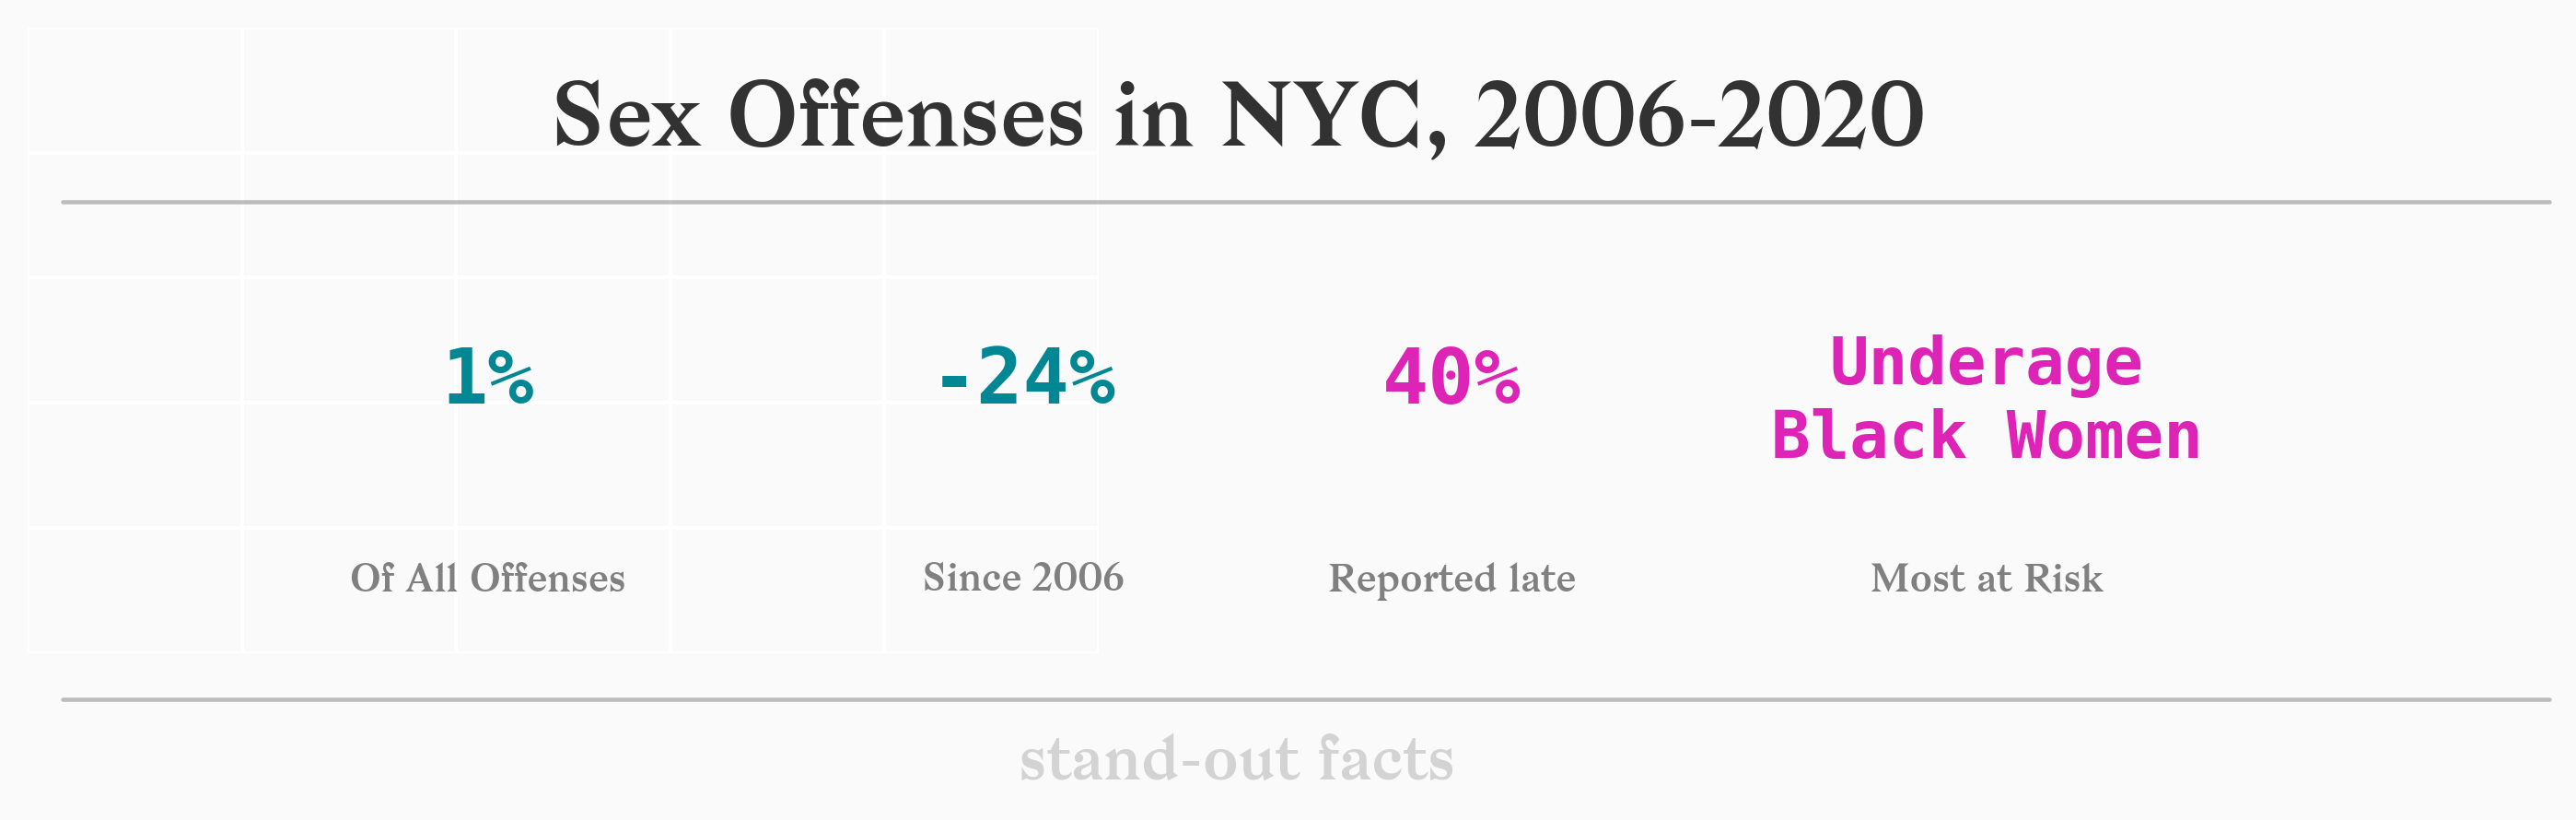

In [28]:
# inspiration ; https://www.kaggle.com/gaetanlopez/how-to-make-clean-visualizations
# changed code signif.

fig = plt.figure(figsize=(5,3),dpi=300)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(1.13,0.85,"Sex Offenses in NYC, 2006-2020",color=colors['title'],fontsize=23, fontweight='bold', fontfamily='bagnard',ha='center', va='center')
ax0.text(1.13,-0.20,"stand-out facts",color='lightgray',fontsize=16, fontweight='bold', fontfamily=fontfamily_titles,ha='center')

ax0.text(0.43,0.4,"1%",color=colors['positive'],fontsize=20, fontweight='bold', fontfamily=fontfamily_numbers,ha='center')
ax0.text(0.43,0.1,"Of All Offenses",color='gray',fontsize=10, fontfamily=fontfamily_titles,ha='center')

ax0.text(0.93,0.4,"-24%",color=colors['positive'],fontsize=20, fontweight='bold', fontfamily=fontfamily_numbers,ha='center')
ax0.text(0.93,0.1,"Since 2006",color='gray',fontsize=10, fontfamily=fontfamily_titles,ha='center')

ax0.text(1.33,0.4,"40%",color=colors['negative'],fontsize=20, fontweight='bold', fontfamily=fontfamily_numbers,ha='center')
ax0.text(1.33,0.1,"Reported late",color='gray',fontsize=10, fontfamily=fontfamily_titles,ha='center')

ax0.text(1.83,0.4,"Underage\nBlack Women",color=colors['negative'],fontsize=17, fontweight='bold', fontfamily=fontfamily_numbers,ha='center', va='center')
ax0.text(1.83,0.1,"Most at Risk",color='gray',fontsize=10, fontfamily=fontfamily_titles,ha='center')

ax0.set_yticklabels('')
ax0.set_xticklabels('')
ax0.tick_params(axis='both',length=0)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
import matplotlib.lines as lines
l1 = lines.Line2D([0.15, 1.95], [0.67, 0.67], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l1])
l2 = lines.Line2D([0.15, 1.95], [0.07, 0.07], transform=fig.transFigure, figure=fig,color = 'gray', linestyle='-',linewidth = 1.1, alpha = .5)
fig.lines.extend([l2])
    
#plt.show()
plt.savefig('../figures/01-first-insights.png', bbox_inches='tight')

* sex offenses amount to just 1% of all offenses, a remarkably small percentage.

# Q1: Did the sexual violence go down in the last 10 years?
## Did the rate of offenses committed at home go up during the pandemic?

In [8]:
yearly_all = data.groupby(data.date_start.dt.year).count().cmp_id.loc[2006:]
yearly_sex = data_sex.groupby(data_sex.date_start.dt.year).count().cmp_id.loc[2006:]

/opt/homebrew/Caskroom/miniforge/base/envs/.venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1389: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
findfont: Font family ['bagnard'] not found. Falling back to DejaVu Sans.
findfont: Font family ['bagnard'] not found. Falling back to DejaVu Sans.
findfont: Font family ['bagnard'] not found. Falling back to DejaVu Sans.


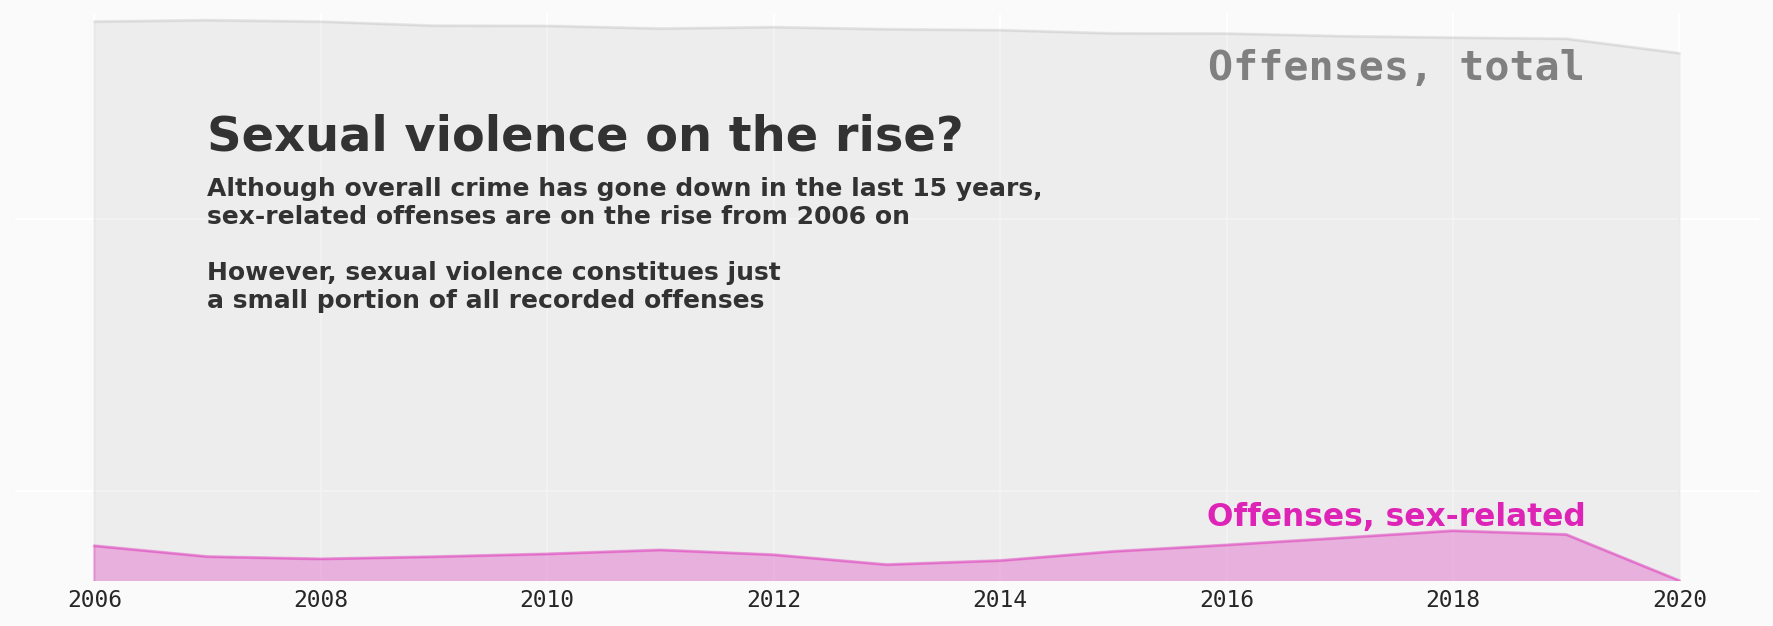

In [9]:
fig = plt.figure(figsize=(15,5),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

yearly_all.plot.area(alpha=0.1, color='grey', label='all', ax=ax0)
plt.yscale('log')
yearly_sex.plot.area(alpha=0.3, color=colors['negative'], label='sex', ax=ax0)

annotation = """
Although overall crime has gone down in the last 15 years,
sex-related offenses are on the rise from 2006 on

However, sexual violence constitues just
a small portion of all recorded offenses
"""
ax0.text(2007,10**5*2,"Sexual violence on the rise?",color=colors['title'],fontsize=23, fontweight='bold', fontfamily='bagnard',ha='left', va='center')
ax0.text(2007,10**5*1.8, annotation,color=colors['title'],fontsize=12, fontweight='bold', fontfamily='bagnard',ha='left', va='top')
ax0.text(2017.5,10**4*0.8,"Offenses, sex-related",color=colors['negative'], fontweight='bold', fontfamily='bagnard',ha='center', va='center', fontsize=15)
ax0.text(2017.5,yearly_all[2017]*0.9,"Offenses, total",color='grey', fontweight='bold', fontfamily='monospace',ha='center', va='top', fontsize=20)

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.set_yticklabels('')
ax0.tick_params(axis='both',length=0)
plt.savefig('../figures/01-sex_violence_on_the_rise.png', bbox_inches='tight')

findfont: Font family ['literata'] not found. Falling back to DejaVu Sans.


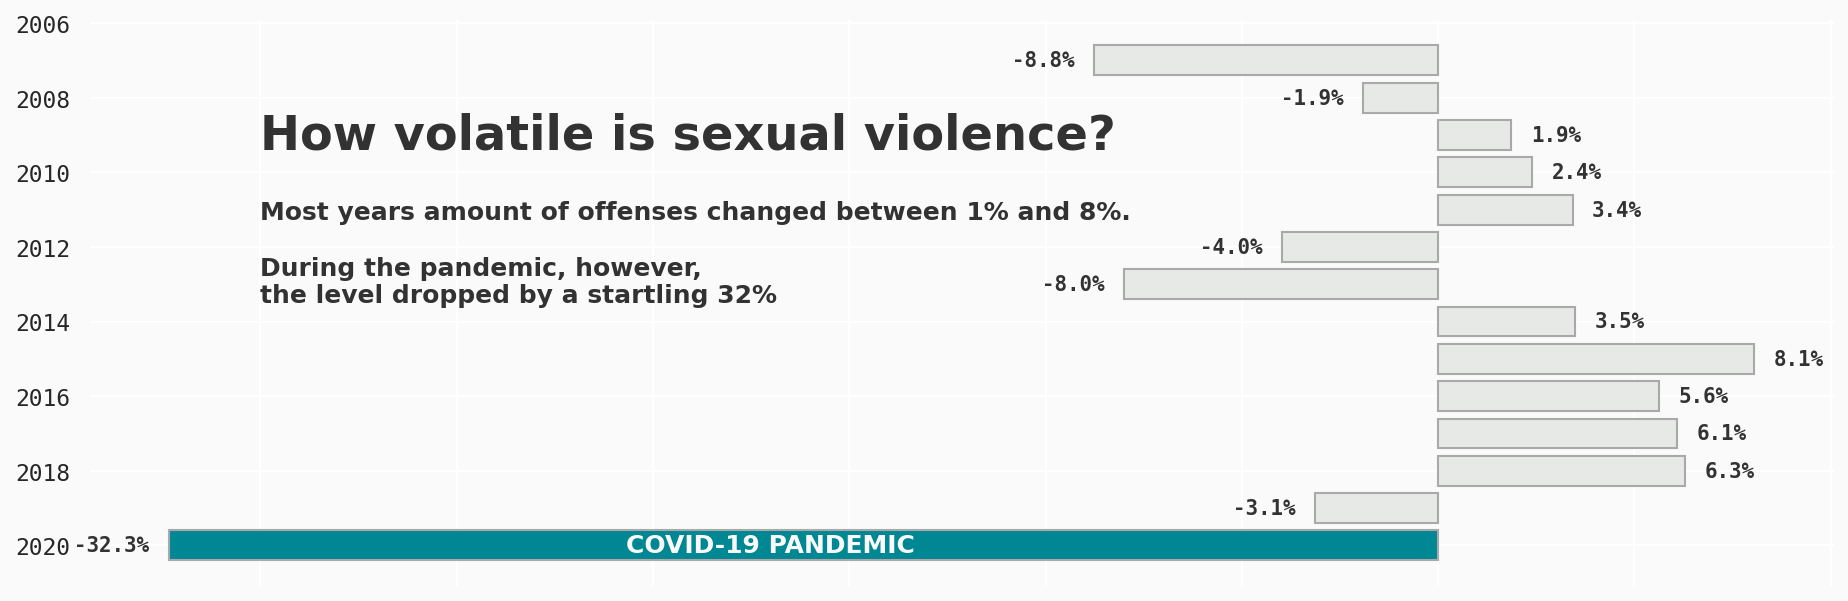

In [10]:
fluctuations = (yearly_sex-yearly_sex.shift(1))/yearly_sex.shift(1)

fig = plt.figure(figsize=(15,5),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

color_map = ['#e7e9e7' for _ in range(len(fluctuations.index))]
color_map[-1] = colors['positive']

ax0.barh(fluctuations.index, fluctuations, edgecolor='darkgray',color=color_map)
plt.gca().invert_yaxis()

annotation = """
Most years amount of offenses changed between 1% and 8%.

During the pandemic, however,
the level dropped by a startling 32%
"""
ax0.text(-0.3, 2009,"How volatile is sexual violence?",color=colors['title'],fontsize=23, fontweight='bold', fontfamily='bagnard',ha='left', va='center')
ax0.text(-0.3, 2010, annotation,color=colors['title'],fontsize=12, fontweight='bold', fontfamily='literata',ha='left', va='top')
ax0.text(-0.17, 2020, 'COVID-19 PANDEMIC', color=background_color,fontsize=12, fontweight='bold', fontfamily='bagnard',ha='center', va='center')

for (year, val) in zip(fluctuations.index, fluctuations):
    if year != 2006:
        if val < 0:
            ax0.text(val-0.005, year,f'{round(val*100, 1)}%',color=colors['title'],fontsize=10, fontweight='bold', ha='right', va='center')
        else:
            ax0.text(val + 0.005, year,f'{round(val*100, 1)}%',color=colors['title'],fontsize=10, fontweight='bold', ha='left', va='center')
        

for s in ['top','right','left','bottom']:
    ax0.spines[s].set_visible(False)
    
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.set_xticklabels('')
#ax0.tick_params(axis='both',length=0)
plt.savefig('../figures/01-fluctuations.png', bbox_inches='tight')

findfont: Font family ['bagnard'] not found. Falling back to DejaVu Sans.
findfont: Font family ['bagnard'] not found. Falling back to DejaVu Sans.
findfont: Font family ['bagnard'] not found. Falling back to DejaVu Sans.


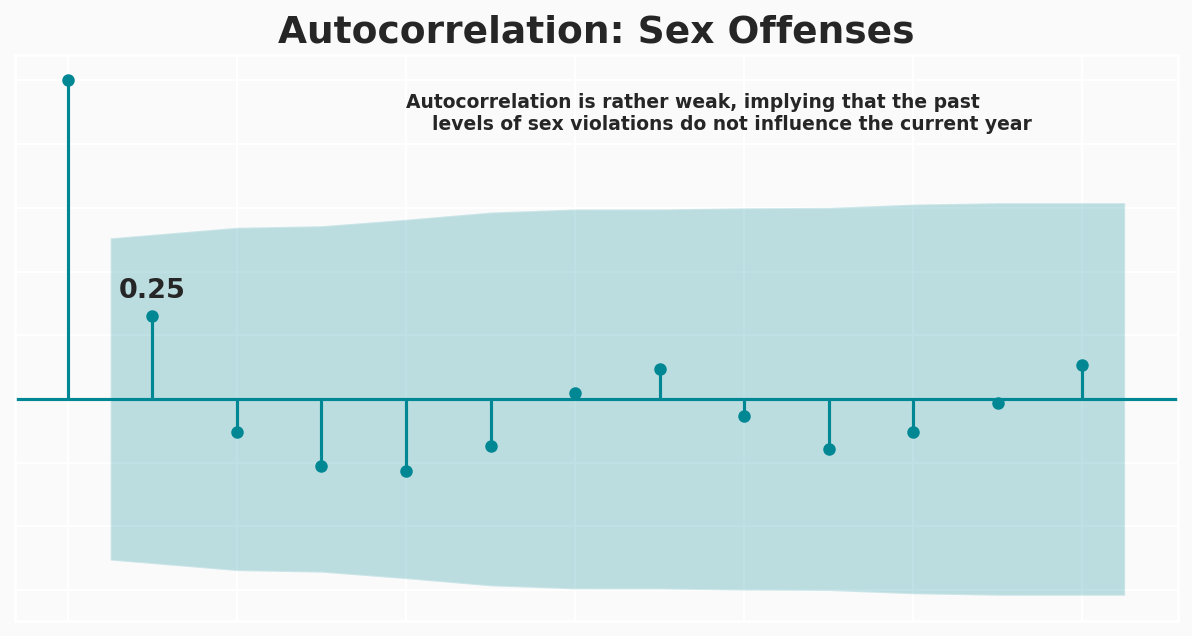

In [14]:
from matplotlib.collections import PolyCollection

fluctuations = (yearly_sex-yearly_sex.shift(1))/yearly_sex.shift(1)
COLOR = colors['positive']

fig = plt.figure(figsize=(10,5),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.4)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

i = plot_acf(yearly_sex, ax=ax0, color=COLOR, vlines_kwargs={"colors": COLOR})
for item in ax0.collections:
    if type(item)==PolyCollection:
        item.set_facecolor(COLOR)
        
plt.title('Autocorrelation: Sex Offenses', fontsize=18, fontweight='bold', fontfamily='bagnard')
ax0.text(4, 0.9, 'Autocorrelation is rather weak, implying that the past\n    levels of sex violations do not influence the current year',
         fontsize=9, fontweight='bold', fontfamily='bagnard',ha='left', va='center')
ax0.text(1, 0.3, 0.25, fontsize=13, fontweight='bold', fontfamily='bagnard',ha='center', va='bottom')
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.set_xticklabels('')
ax0.set_yticklabels('')
plt.savefig('../figures/01-autocorrelation.png')

In [15]:
yearly_offense = data_sex.groupby([data_sex.date_start.dt.year, 'internal_desc']).count().cmp_id.loc[2006:,:].unstack().loc[[2006,2019,2020]].T
yearly_offense = yearly_offense[yearly_offense.index != "Obscenity"]
yearly_offense

date_start,2006,2019,2020
internal_desc,,,
Child Endangerment,1715,1668,1189
Rape,1524,1477,1035
Sex Abuse,2723,3405,2232
Sex Misconduct,319,367,224


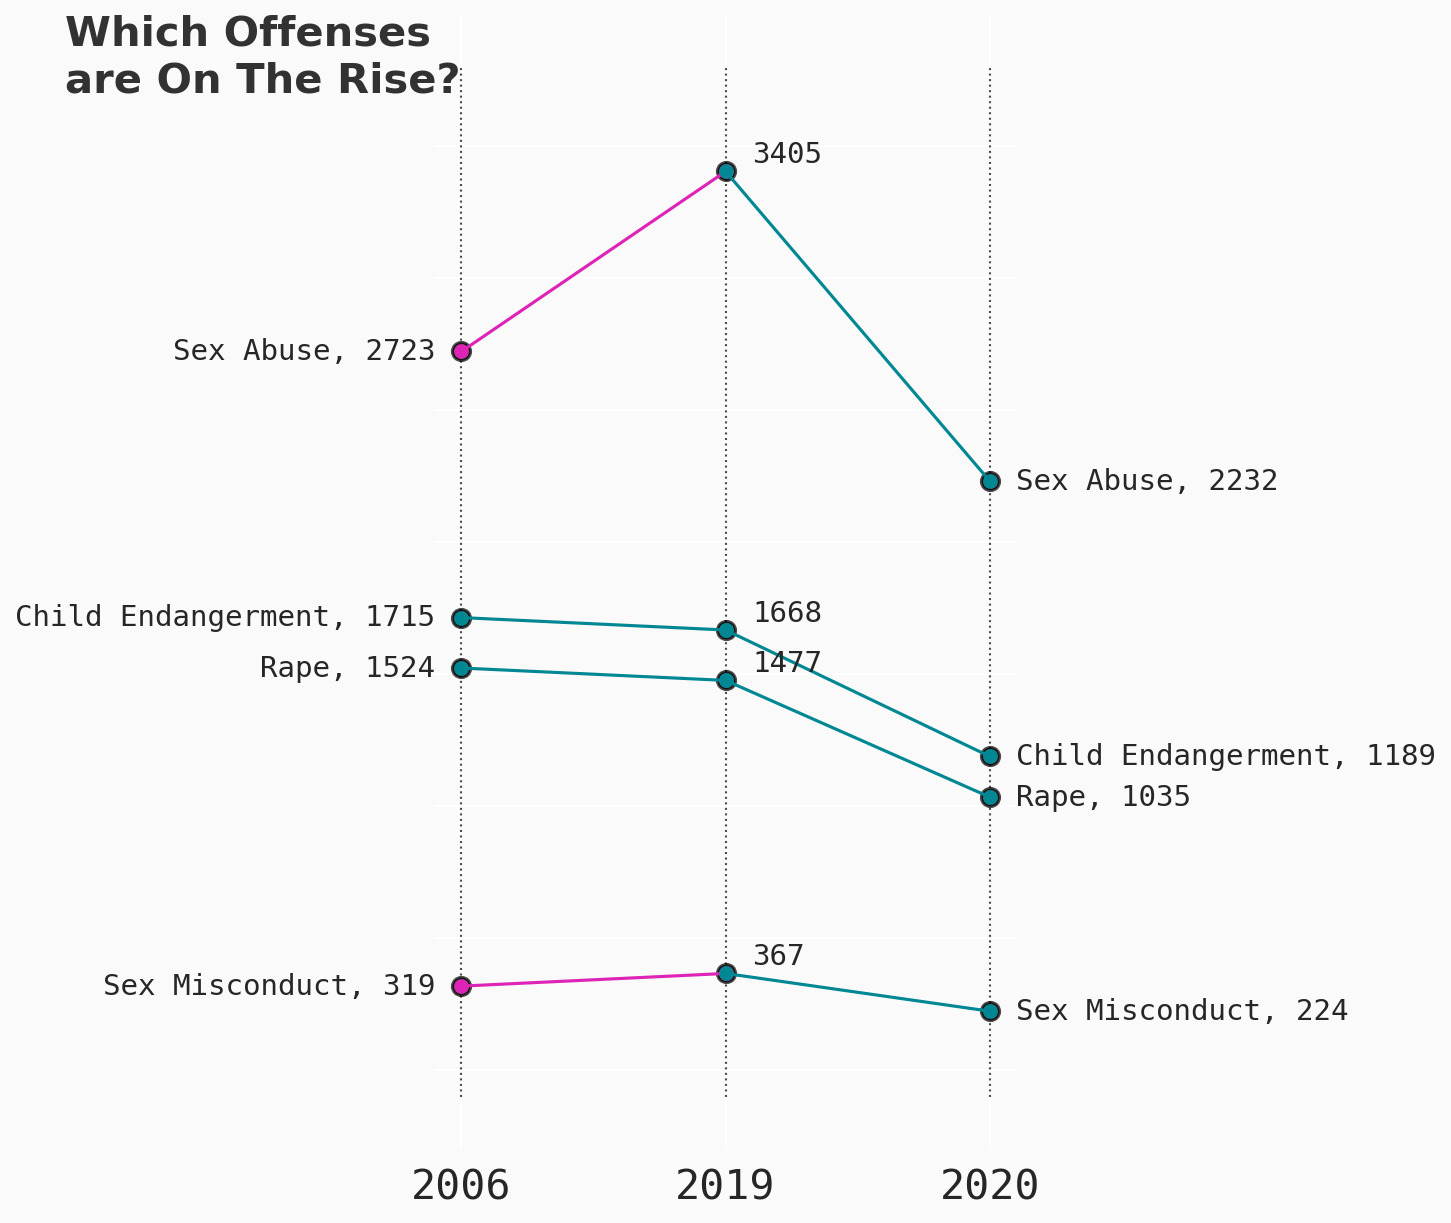

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.lines as mlines

left_label = [str(c) + ', '+ str(round(y)) for c, y in zip(yearly_offense.index, yearly_offense[2006])]
mid_label = [str(round(y)) for y in yearly_offense[2019]]
right_label = [str(c) + ', '+ str(round(y)) for c, y in zip(yearly_offense.index, yearly_offense[2020])]
klass1 = [colors['positive'] if (y1-y2) < 0 else colors['negative'] for y1, y2 in zip(yearly_offense[2006], yearly_offense[2019])]
klass2 = [colors['positive'] if (y2-y3) < 0 else colors['negative'] for y2, y3 in zip(yearly_offense[2019], yearly_offense[2020])]

# draw line
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib/36479941
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color=colors['positive'] if p1[1]-p2[1] > 0 else colors['negative'], marker='o', markersize=6)
    ax.add_line(l)
    return l

fig, ax = plt.subplots(1,1,figsize=(5,10), dpi= 150, facecolor=background_color)
ax.set_facecolor(background_color)

# Vertical Lines
ax.vlines(x=1, ymin=-100, ymax=3800, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=3, ymin=-100, ymax=3800, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
ax.vlines(x=5, ymin=-100, ymax=3800, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# Points
ax.scatter(y=yearly_offense[2006], x=np.repeat(1, yearly_offense.shape[0]), s=75,linewidth=1.5, color='black', alpha=0.7)
ax.scatter(y=yearly_offense[2019], x=np.repeat(3, yearly_offense.shape[0]), s=75, linewidth=1.5,color='black', alpha=0.7)
ax.scatter(y=yearly_offense[2020], x=np.repeat(5, yearly_offense.shape[0]), s=75, linewidth=1.5,color='black', alpha=0.7)

# Line Segments and Annotation
for p1, p2, c in zip(yearly_offense[2006], yearly_offense[2019], yearly_offense.index):
    newline([1,p1], [3,p2])
    ax.text(1-0.2, p1, c + ', ' + str(round(p1,1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':14})
    ax.text(3+0.2, p2+10, str(round(p2,1)), horizontalalignment='left', verticalalignment='bottom', fontdict={'size':14})
    
for p1, p2, c in zip(yearly_offense[2019], yearly_offense[2020], yearly_offense.index):
    newline([3,p1], [5,p2])
    ax.text(5+0.2, p2, c + ', ' + str(round(p2,1)), horizontalalignment='left', verticalalignment='center', fontdict={'size':14})


ax.text(-2,4000,"Which Offenses\nare On The Rise?", fontsize=20, fontfamily='bagnard',fontweight='bold',color='#323232', ha='left', va='top')
#ax.text(0,8.5, '', fontsize=12, fontweight='light', fontfamily='monospace',color='gray')


#ax.set(xlim=(0,4), ylim=(3,8.2), ylabel='')
ax.set_xticks([1,3,5])
ax.set_xticklabels(["2006", "2019", "2020"],fontsize=20)
#plt.yticks(np.arange(3, 3500, 2), fontsize=12)

for s in ["top","right","left","bottom"]:
    ax.spines[s].set_visible(False)
    
ax.tick_params(axis='both',which='both',left=False,bottom=False,labelleft=False) 
plt.rcParams["font.family"] = "monospace"

plt.show()
plt.savefig('../figures/01-offesnes-on-the-rise.png', bbox_inches='tight')

# Q2: Who suffers from sex offenses the most?

In [17]:
temp = data_sex.groupby(['internal_desc', 'vic_race']).count().cmp_id.unstack()
temp = temp.divide(temp.sum(1), axis=0).T.fillna(0).sort_values(by='Rape').tail(20).iloc[::-1].T
temp['Other'] = temp[[col for col in temp.columns if col not in ["Black", "White hispanic"]]].sum(1)
temp = temp[['Black', "White hispanic", 'Other']]
temp.sum(1)

internal_desc
Child Endangerment    1.0
Obscenity             1.0
Rape                  1.0
Sex Abuse             1.0
Sex Misconduct        1.0
dtype: float64

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_15233/2345494111.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)


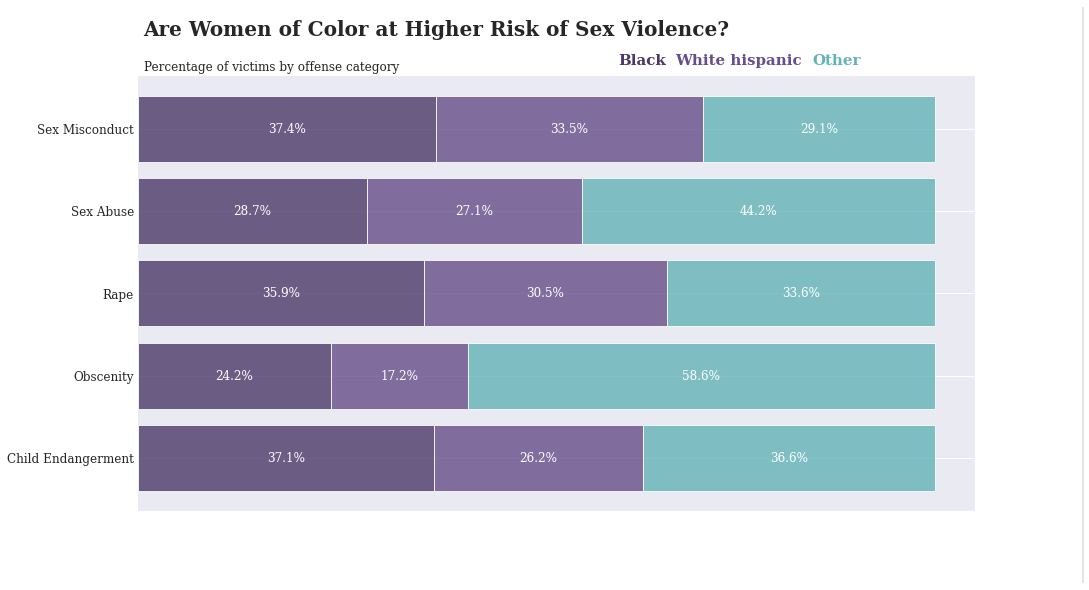

In [700]:
data_q2q3_ratio = temp




###
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Black'],
        color='#4B3869', alpha=0.8, label='Black')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['White hispanic'], left=data_q2q3_ratio['Black'], 
        color='#664E88', alpha=0.8, label='White hispanic')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Other'], left=data_q2q3_ratio['White hispanic'] + data_q2q3_ratio['Black'], 
        color='#63B4B8', alpha=0.8, label='Other')


#ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)


# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Black'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Black'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    
    ax.annotate(f"{data_q2q3_ratio['White hispanic'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Black'][i]+data_q2q3_ratio['White hispanic'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    
    ax.annotate(f"{data_q2q3_ratio['Other'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Black'][i]+data_q2q3_ratio['White hispanic'][i] + data_q2q3_ratio['Other'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.95, 'Are Women of Color at Higher Risk of Sex Violence?', fontsize=20, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percentage of victims by offense category', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

fig.text(0.57,0.9,"Black", fontweight="bold", fontfamily='serif', fontsize=15, color='#4B3869')
fig.text(0.74,0.9,"White hispanic", fontweight="bold", fontfamily='serif', fontsize=15, color='#664E88', ha='right')
fig.text(0.75,0.9,"Other", fontweight="bold", fontfamily='serif', fontsize=15, color='#63B4B8', ha='left')

import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig('../figures/02-pct-race-offense.png')

Values for black and hispanic women are very close. How likely that is due to chance?

In [ ]:
# victims of rape are fairly distributed across groups - max 5% per group

In [19]:
def parse_vic_group(vic):
    subgroups = vic.split('_')
    subgroups[1] = 'Men,' if subgroups[1] == 'M' else 'Women,'
    subgroups[2] = ' age ' + subgroups[2]
    return ' '.join(subgroups)

In [20]:
def plot_victim_groups_by_year(data, offense_cat=None, top=20):
    query_substr = '' if offense_cat is None else f' and (internal_desc == "{offense_cat}")'
    
    temp = data_sex.query(f'(vic_race != "Unknown") and (vic_sex in ["F", "M"]){query_substr}')
        
    top_vic_groups = (temp.groupby([temp.date_start.dt.year, 'vic_group']).count().cmp_id.loc[2006:,:]\
                      / temp.groupby([temp.date_start.dt.year]).count().cmp_id.loc[2006:] * 100)\
        .unstack().fillna(0).T.sort_values(by=2006).iloc[::-1].head(top).iloc[::-1]

    top_vic_groups.index = list(map(parse_vic_group, top_vic_groups.index))
    
    background = "#fbfbfb"
    fig, ax = plt.subplots(1,1, figsize=(10, 10),dpi=150)
    fig.patch.set_facecolor(background)
    ax.set_facecolor(background)


    for i, vic in enumerate(top_vic_groups.index):
        vic_data=top_vic_groups.loc[[vic]]
        mean = vic_data.mean(1)

        plt.scatter(x=vic_data.loc[vic], y=[i+1]*len(vic_data.loc[vic]), color='lightgrey',linewidth=1,s=50, ec='white')
        sns.scatterplot(y=i+1, x=mean, color=colors['positive'],ec='black',linewidth=1,s=75,ax=ax)
        sns.scatterplot(data=vic_data, y=i+1, x=2020,color='red',ec='black',linewidth=1,s=75,ax=ax)   

    ax.set_yticks(top_vic_groups.reset_index().index+1)
    ax.set_yticklabels(top_vic_groups.index, fontdict={'horizontalalignment': 'right'}, alpha=0.7)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xlabel(f"Percentage of {'all' if offense_cat is None else offense_cat} victims",fontfamily='bagnard',loc='left',color='gray')

    for s in ['top','right','bottom','left']:
        ax.spines[s].set_visible(False)

    Xstart, Xend = ax.get_xlim()
    Ystart, Yend = ax.get_ylim()

    ax.hlines(y=top_vic_groups.reset_index().index+1, xmin=Xstart, xmax=Xend, color='gray', alpha=0.5, linewidth=.3, linestyles='--')
    ax.set_axisbelow(True)
    ax.text(0, Yend+3, 'Are Women of Color more likely to be raped?', fontsize=17, fontweight='bold', fontfamily='bagnard',color='#323232', ha='left', va='bottom')
    ax.text(0, Yend+3,
    '''
    Although proportions do vary over time, they are quite consistent.
    
    - Most at risk groups are black and hispanic women
    - Most victims are fairly young, and minors face highest risk
    - Although majority of victims are female, underage men\n         are facing a rather high risk of sex abuse
    ''', fontsize=9, fontweight='light', fontfamily='monospace',color='gray', ha='left', va='top')
    
    plt.annotate('2021\nscore', xy=(top_vic_groups.iloc[16][2020], 17), xytext=(top_vic_groups.iloc[16].mean()+2, 12.5),
             arrowprops=dict(color='grey', arrowstyle="->",),
                 fontsize=10,fontfamily='monospace',ha='center', color='red')

    plt.annotate('Mean\nscore', xy=(top_vic_groups.iloc[18].mean(), 19), xytext=(top_vic_groups.iloc[18].mean()+1, 16.5),
             arrowprops=dict(color='grey',arrowstyle="->",connectionstyle="arc3,rad=.5"),
                 fontsize=10,fontfamily='monospace',ha='center', color=colors['positive'])

    plt.tight_layout()
    plt.savefig(f'../figures/02-victims-pct-volatility{"" if offense_cat is None else "-" + offense_cat.lower()}.png')
    
    return fig

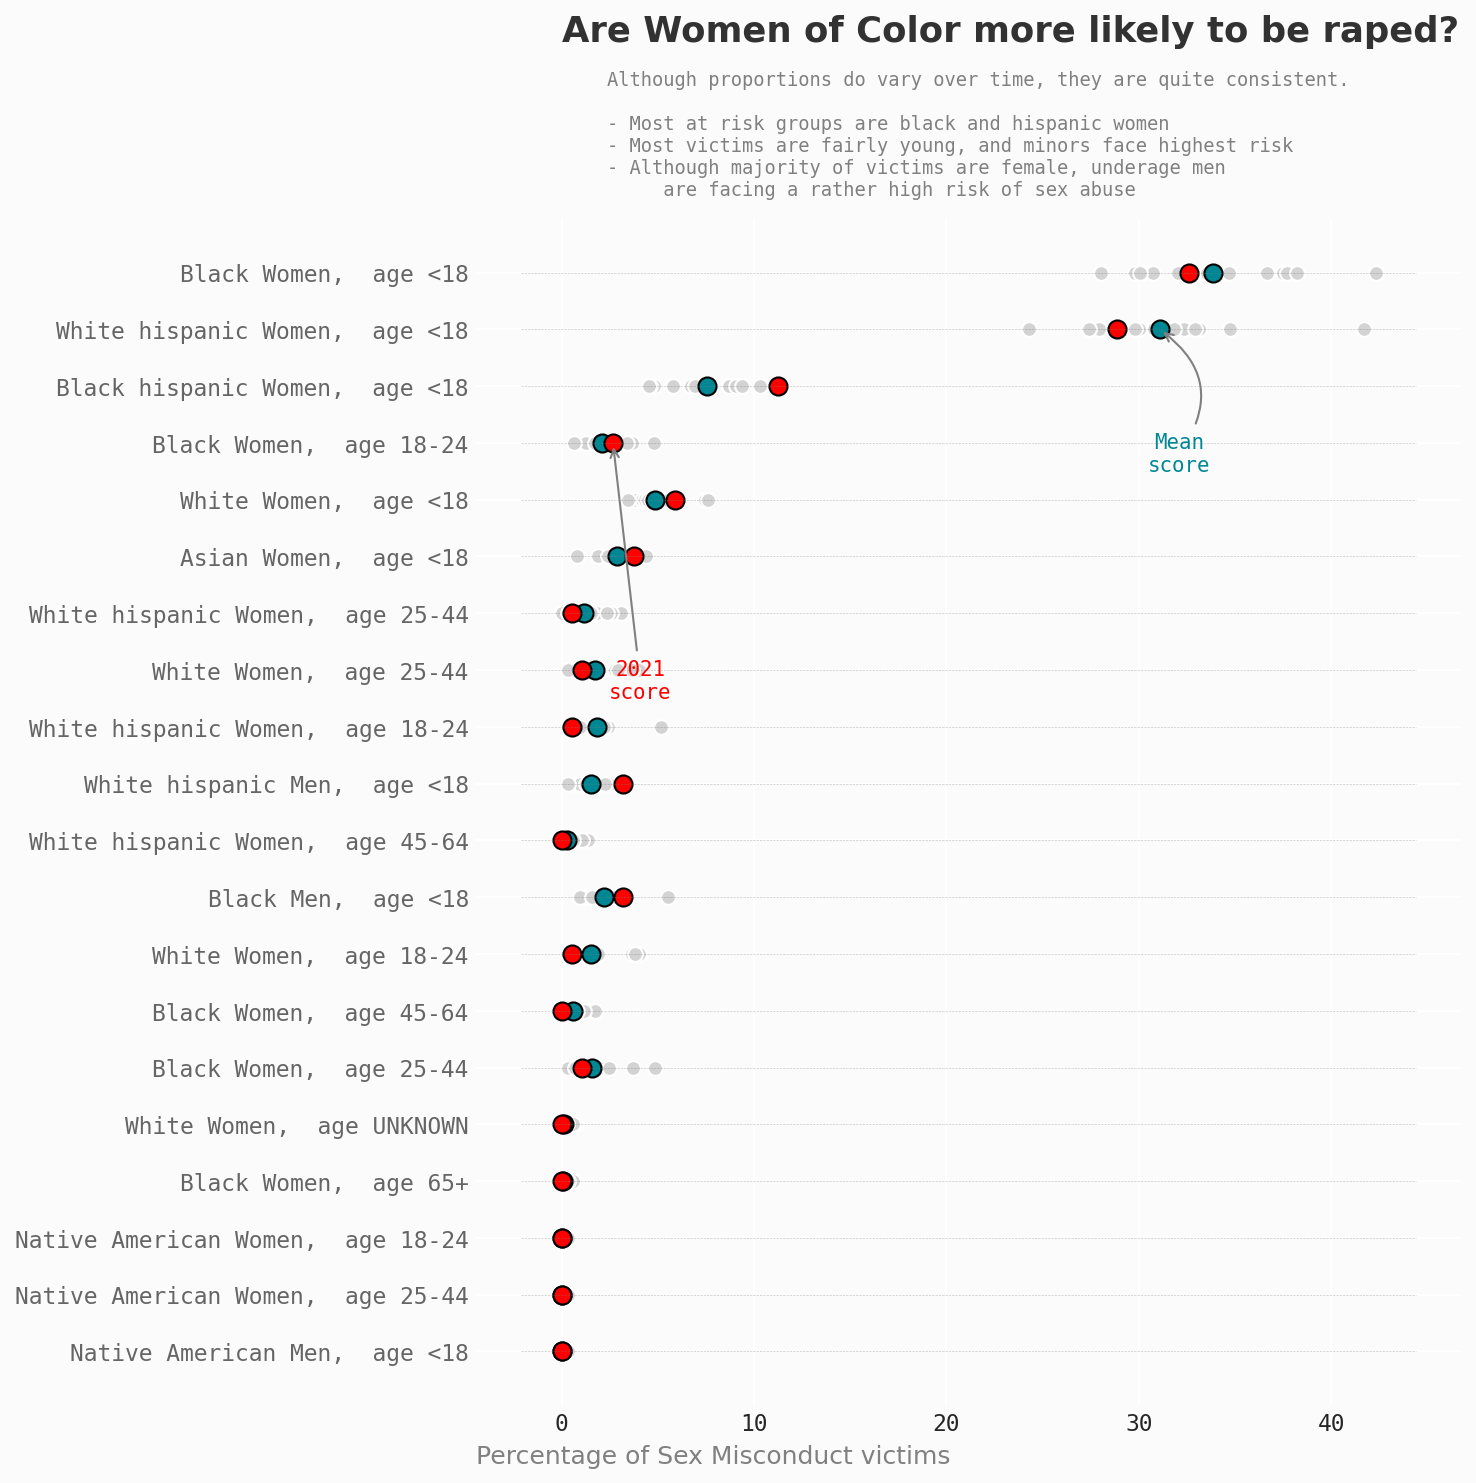

In [22]:
fig = plot_victim_groups_by_year(data_sex, 'Sex Misconduct')

# Q3: Where sexual violence usually occurs (home/street/office)?

In [12]:
data_sex.loc_premises = data_sex.loc_premises.str.lower().str.capitalize()
top_premises = data_sex.loc_premises.value_counts()[:10].index
data_sex.loc_premises = data_sex.loc_premises.apply(lambda pr: pr if pr in top_premises else 'Other')

/Users/nastja/.pyenv/versions/py39/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
MAP_PREMISES = {pr: pr for pr in data_sex.loc_premises.unique()}
MAP_PREMISES.update({
    'Residence - apt. house': 'Residence',
    'Residence-house': 'Residence',
    'Street': 'Street',
    'Transit - nyc subway': 'Public Transport',
    'Hotel/motel': 'Hotel',
    'Park/playground': 'Park',
    'Bar/night club ': 'Bar or Club',
    'Grocery/bodega': 'Grocery',
    'Bus (nyc transit)': 'Public Transport',
    'Doctor/dentist office': "Doctor's Office",
    'Fast food': 'Restaurant',
    'Restaurant/diner': 'Restaurant',
})
data_sex.loc_premises = data_sex.loc_premises.map(MAP_PREMISES)

In [14]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#4B3869', '#664E88','#63B4B8'])

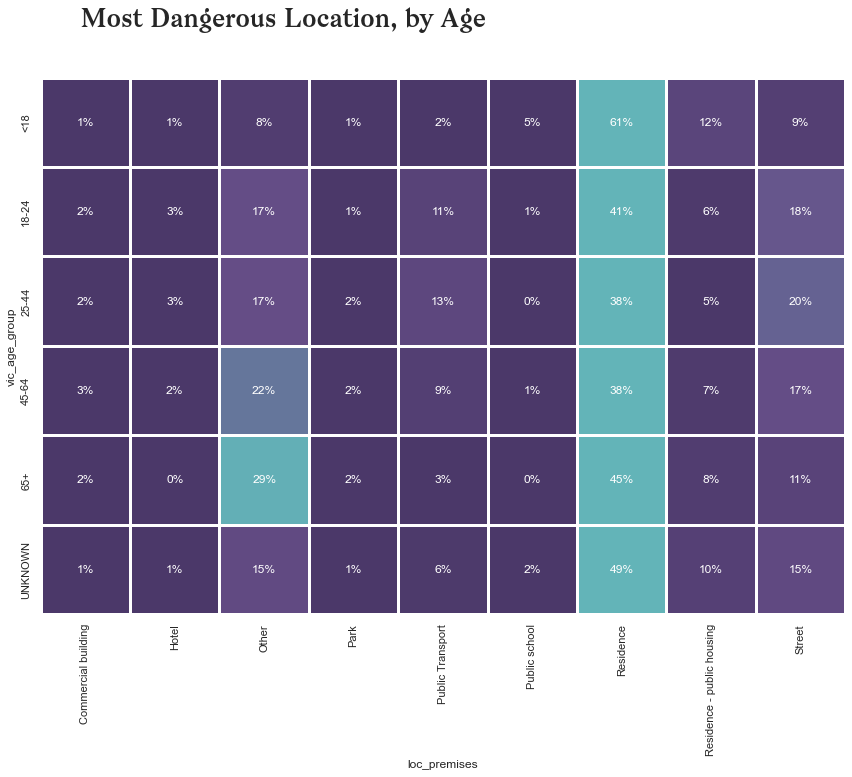

In [915]:
temp = data_sex.groupby(['loc_premises', 'vic_age_group']).count().cmp_id.unstack().T
temp_rape = data_sex[data_sex.internal_desc=='Rape'].groupby(['loc_premises', 'vic_age_group']).count().cmp_id.unstack().T.fillna(0)

fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)

age_order = ['<18','18-24','25-44','45-64', '65+', 'UNKNOWN']

sns.heatmap(temp.divide(temp.sum(1), axis=0).loc[age_order,:], cmap=cmap,square=True, linewidth=2.5,cbar=False,
            annot=True,fmt='1.0%',annot_kws={"fontsize":12}, vmax=0.3, ax=axs, vmin=0.05)

ax.spines['top'].set_visible(True)


fig.text(0.1, 0.9, 'Most Dangerous Location, by Age', fontweight='bold', fontfamily='bagnard', fontsize=25,ha='left')   

ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()

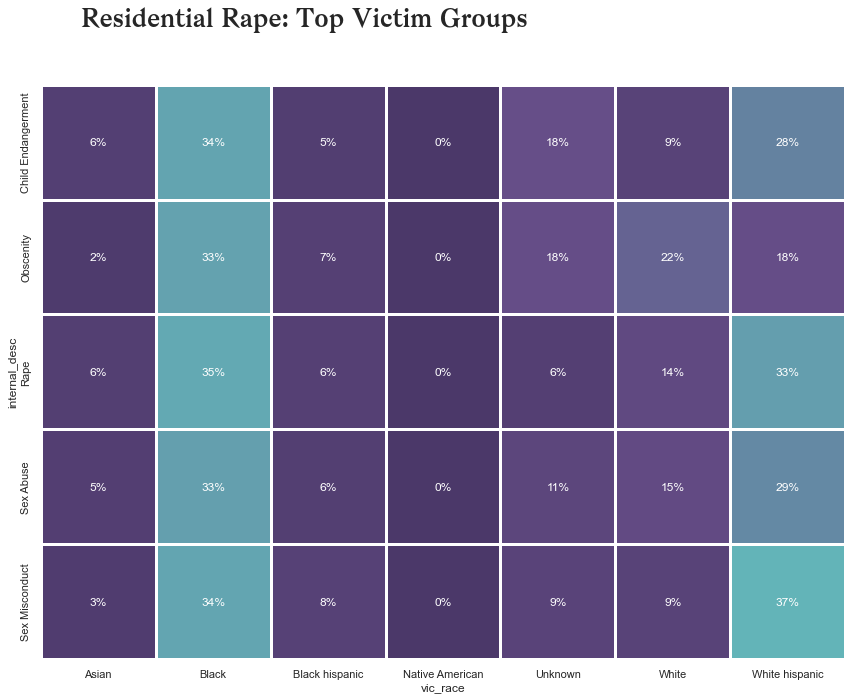

In [911]:
temp = data_sex[data_sex.loc_premises=='Residence'].groupby(['internal_desc', 'vic_race']).count().cmp_id.unstack().T.fillna(0).T

fig, axs = plt.subplots(1, 1, figsize=(12, 12), sharey=True)

sns.heatmap(temp.divide(temp.sum(1), axis=0), cmap=cmap,square=True, linewidth=2.5,cbar=False,
            annot=True,annot_kws={"fontsize":12}, ax=axs, fmt='1.0%')

ax.spines['top'].set_visible(True)


fig.text(0.1, 0.9, 'Residential Rape: Top Victim Groups', fontweight='bold', fontfamily='bagnard', fontsize=25,ha='left')   

ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()

# Q4: With sexual offense commited on the streets, what are the hotspots in NYC?

In [15]:
df_borough_pop = pd.Series({'BROOKLYN': 2736074,
                  'QUEENS': 2405464,
                  'BRONX': 1472654,
                  'MANHATTAN': 1694251,
                  'STATEN ISLAND': 495747})
df_borough_pop.sort_values()

STATEN ISLAND     495747
BRONX            1472654
MANHATTAN        1694251
QUEENS           2405464
BROOKLYN         2736074
dtype: int64

In [16]:
data_sex[data_sex.loc_premises=='Residence'].loc_borough.value_counts()

BROOKLYN         16154
QUEENS           11826
BRONX            10193
MANHATTAN         6052
STATEN ISLAND     1806
Name: loc_borough, dtype: int64

In [25]:
borough_res = data_sex[data_sex.loc_premises=='Residence'].loc_borough.value_counts()
borough_res = pd.concat([borough_res, data_sex[data_sex.loc_premises!='Residence'].loc_borough.value_counts()], axis=1)
borough_res.columns = ['Residence', 'Public']
#borough_res = borough_res.divide(borough_res.sum(1), axis=0)
borough_res

,Residence,Public
BROOKLYN,16154,12490
QUEENS,11826,8719
BRONX,10193,7446
MANHATTAN,6052,15814
STATEN ISLAND,1806,1304


In [18]:
# Manhattan has lowest pct of Black people
temp = data_sex[data_sex.loc_premises!='Residence'].groupby(['vic_race', 'loc_borough']).count().cmp_id.unstack().T
temp.divide(temp.sum(1), axis=0)

vic_race,Asian,Black,Black hispanic,Native American,Unknown,White,White hispanic
loc_borough,,,,,,,
BRONX,0.010878,0.353075,0.109320,0.001746,0.109052,0.056272,0.359656
BROOKLYN,0.045396,0.451641,0.035629,0.002002,0.090472,0.179103,0.195757
MANHATTAN,0.074301,0.245668,0.053876,0.002846,0.096623,0.308524,0.218161
QUEENS,0.148985,0.249455,0.031426,0.005391,0.075353,0.164124,0.325267
STATEN ISLAND,0.025307,0.256135,0.029141,0.003067,0.095092,0.355828,0.235429


In [23]:
background_color = '#fafafa'

In [30]:
a = 598789686
f'{a:,}'

'598,789,686'

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_19253/135902367.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)


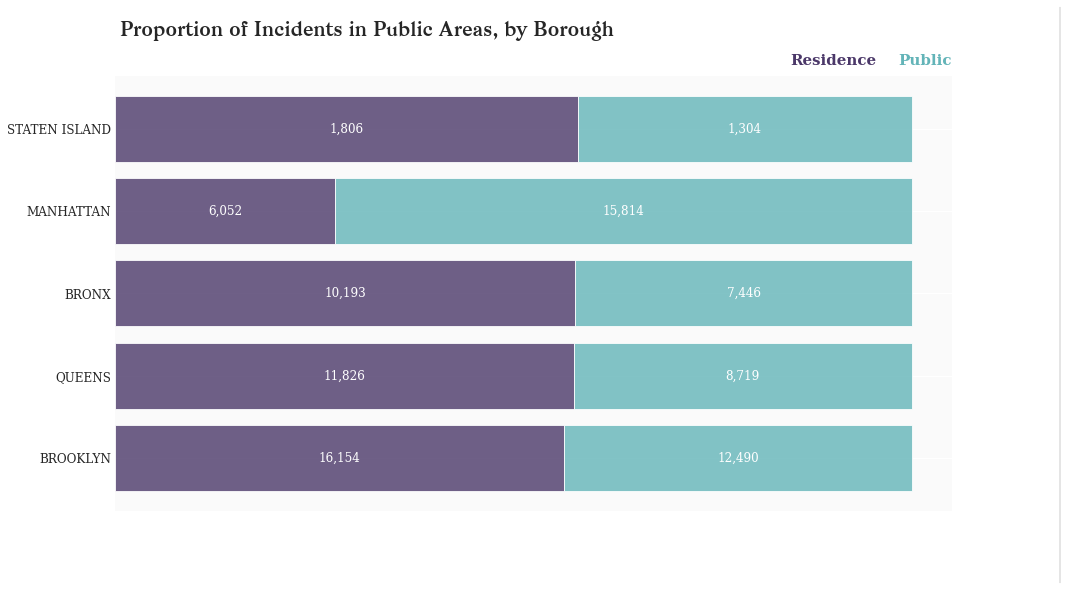

In [33]:
data_q2q3_ratio = borough_res.divide(borough_res.sum(1), axis=0)


###
fig, ax = plt.subplots(1,1,figsize=(15, 8),)
ax.set_facecolor(background_color)

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Residence'],
        color='#4B3869', alpha=0.8, label='Residence')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Public'], left=data_q2q3_ratio['Residence'], 
        color='#63B4B8', alpha=0.8, label='Public')


#ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)


# male percentage
for i in data_q2q3_ratio.index:
    ax.annotate(f"{borough_res['Residence'][i]:,}",#f"{data_q2q3_ratio['Residence'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Residence'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    
    ax.annotate(f"{borough_res['Public'][i]:,}",#f"{data_q2q3_ratio['Public'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Residence'][i]+data_q2q3_ratio['Public'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    

fig.text(0.13, 0.95, 'Proportion of Incidents in Public Areas, by Borough', fontsize=20, fontweight='bold', fontfamily='bagnard')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

fig.text(0.75,0.9,"Residence", fontweight="bold", fontfamily='serif', fontsize=15, color='#4B3869')
fig.text(0.9,0.9,"Public", fontweight="bold", fontfamily='serif', fontsize=15, color='#63B4B8', ha='right')

import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.savefig('../figures/02-pct-race-offense.png')

In [41]:
data_sex['is_residence'] = (data_sex.loc_premises == "Residence")

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_19253/3787417810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sex['is_residence'] = (data_sex.loc_premises == "Residence")


In [54]:
temp = data_sex.groupby([data_sex.date_start.dt.year, 'loc_borough', 'is_residence']).loc_precinct.count().loc[2006:,:,:].unstack()
temp['pct_public'] = (temp[False] / (temp[True] + temp[False]) * 100).round(2)
temp.loc[2009]

is_residence,False,True,pct_public
loc_borough,,,
BRONX,437,662,39.76
BROOKLYN,724,1051,40.79
MANHATTAN,965,319,75.16
QUEENS,553,806,40.69
STATEN ISLAND,84,132,38.89


BRONX
MANHATTAN
QUEENS
STATEN ISLAND
BROOKLYN
nan


KeyError: nan

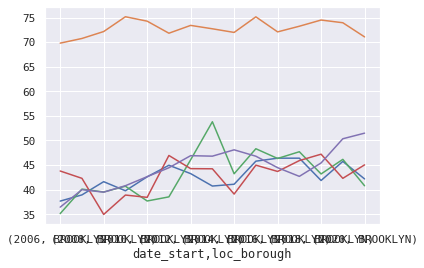

In [60]:
for borough in data_sex.loc_borough.unique():
    print(borough)
    temp.loc[:,borough,:].pct_public.plot()

<AxesSubplot:xlabel='date_start,loc_borough'>

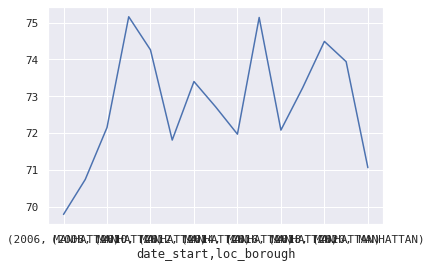

In [57]:
temp.loc[:,'MANHATTAN',:].pct_public.plot()

# Q5: Are people more willing to report sexual offenses since Me Too movement started?

In [952]:
data_sex['days_till_report'] = (data_sex.date_reported - data_sex.date_start).dt.days

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_15233/2247802850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sex['days_till_report'] = (data_sex.date_reported - data_sex.date_start).dt.days


In [957]:
data_sex['days_till_report'].describe()

count    91859.000000
mean       158.981047
std        819.183971
min          0.000000
25%          0.000000
50%          1.000000
75%         10.000000
max      36527.000000
Name: days_till_report, dtype: float64

<AxesSubplot:xlabel='days_till_report', ylabel='vic_age_group'>

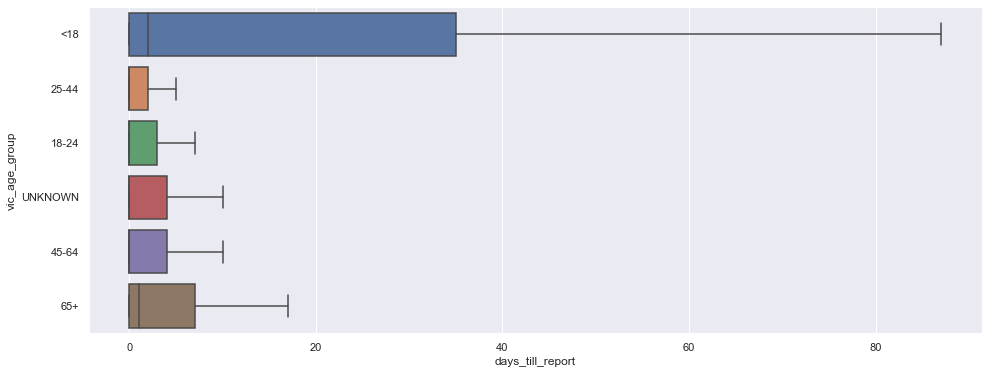

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
sns.boxplot(data=data_sex, y='vic_age_group', x='days_till_report', showfliers=False, ax=ax)

In [1042]:
vals = data_sex.groupby('vic_group').days_till_report.mean().sort_values()
slowest_to_report = vals.tail(10).index

<AxesSubplot:xlabel='days_till_report', ylabel='vic_group'>

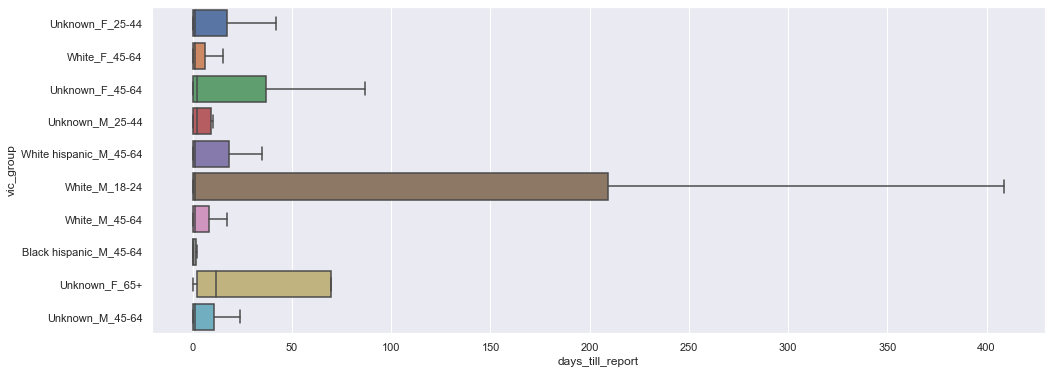

In [1043]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
sns.boxplot(data=data_sex[data_sex.vic_group.isin(slowest_to_report)], y='vic_group', x='days_till_report', showfliers=False, ax=ax)

/var/folders/8w/pj7s5vq54kb7tqh8qpy_pxsc0000gn/T/ipykernel_15233/3429975071.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sex['reported_within_week'] = (data_sex.days_till_report <= 7)


<AxesSubplot:xlabel='date_start'>

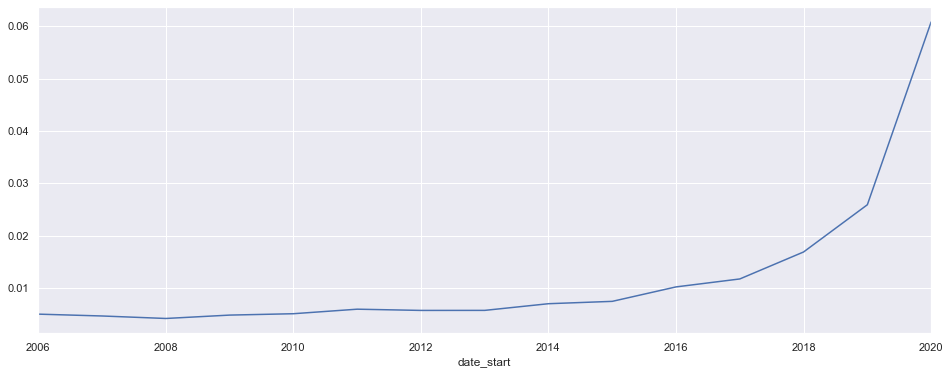

In [1021]:
data_sex['reported_within_week'] = (data_sex.days_till_report <= 7)

fig, ax = plt.subplots(1,1,figsize=(16,6))
dd = data_sex.groupby([data_sex.date_start.dt.to_period('Y'), 'reported_within_week']).days_till_report.sum().loc['2006':].unstack()
(dd[True]/ dd.sum(1)).plot()

<AxesSubplot:xlabel='date_start'>

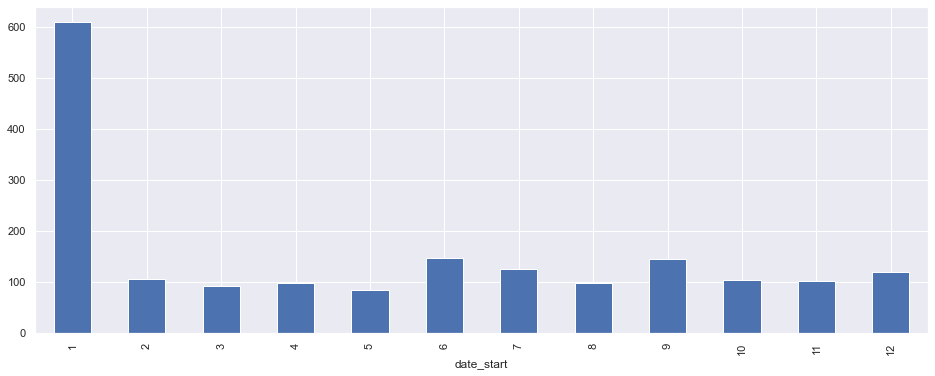

In [985]:
# Why January? When date unknwon - attributed to Jan 1st
fig, ax = plt.subplots(1,1,figsize=(16,6))
data_sex.groupby(data_sex.date_start.dt.month).days_till_report.mean().plot.bar()